<a href="https://colab.research.google.com/github/spike-h/AP-PA-Classifier/blob/main/Dataset_Creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

##Pips (restart runtime after running)

In [3]:
'''
 importing from https://github.com/Engineero/tf_sprinkles
'''
!pip install tf_sprinkles &> /dev/null
!pip install pydicom &> /dev/null
!pip install pylibjpeg pylibjpeg-libjpeg  &> /dev/null
!pip install python-gdcm &> /dev/null
!pip install -q tensorflow-io &> /dev/null
!pip install numpy --upgrade

     |████████████████████████████████| 15.7 MB 211 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


##imports

In [1]:
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import random
from tf_sprinkles import Sprinkles
import pydicom
from tqdm import tqdm
import pylibjpeg
import gdcm
import tensorflow_io as tfio
import time
# import tracemalloc

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

TF version: 2.6.0
Hub version: 0.12.0


In [2]:
colabDir = '/content/drive/MyDrive/AP PA Stuff/Datasets/Original/'
tensorflowDir = '/content/drive/MyDrive/AP PA Stuff/Datasets/Tensorflow/'

In [3]:
!pip install cache-magic
import cache_magic
!ln -s '/content/drive/MyDrive/AP PA Stuff/Datasets/cache' /content/.cache

  Created wheel for cache-magic: filename=cache_magic-1.0.4-py3-none-any.whl size=6696 sha256=55bf7571c0638956066b43d2667b6b4702c32b05844ca92d2c4316c4a15a822d
  Stored in directory: /root/.cache/pip/wheels/24/16/f2/016dbddf24f703cf51ad82bb88ca3a77458b20199acd3a5590
Successfully built cache-magic


#Creating tf.data.Dataset Datasets

##Helper/Starter functions

In [4]:
class_distributions = {}

In [5]:
#Sprinkles augmentation setup

#Set sprinkles to make 50-100 square holes in the image with side length of 10 pixels 30% ofthe time
class RandomSprinkles(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()

  def call(self, image):
    sprinkles = Sprinkles(num_holes=random.randint(0,50), side_length=10)
    return sprinkles(image)

In [6]:
#Helper functions to create and augment the tf.data.Datasets
IMG_SIZE = 256 #IF CHANGE HERE THEN ALSO CHANGE IN TRAIN MODEL.py
BATCH_SIZE = 16 #IF CHANGE HERE THEN ALSO CHANGE IN TRAIN MODEL.py
rngJesus = 8679309 #set seed for consistency when running but doesnt affect sprinkles soooooo maybe pointless

def read_image(filename, label, bmp=None):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_image(image_string, channels=3, expand_animations=False)
  image = tf.cast(image_decoded, tf.float32) / 255.0
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  return image, label

def read_dicom_image(dcmFile, label):
  # image_decoded = tf.convert_to_tensor(dcmFile)
  # image_decoded = tf.expand_dims(image_decoded, axis=-1)
  image = tf.image.grayscale_to_rgb(dcmFile)
  print('a')
  image = tf.cast(image, tf.float32) / 255.0
  print('b')
  # image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  return image, label

preprocessing_model = tf.keras.Sequential([
  RandomSprinkles(),
  tf.keras.layers.RandomFlip("horizontal", seed=rngJesus),
  tf.keras.layers.RandomContrast(factor=0.1, seed=rngJesus),
  tf.keras.layers.RandomTranslation(0, 0.1, fill_mode='constant', seed=rngJesus),
  tf.keras.layers.RandomTranslation(0.1, 0, fill_mode='constant', seed=rngJesus),
  tf.keras.layers.RandomRotation(.046, fill_mode='constant', seed=rngJesus)
])
# preprocessing_model.add(
#   tf.keras.layers.RandomRotation(.111, fill_mode='constant', seed=rngJesus)),
# preprocessing_model.add(
#   tf.keras.layers.RandomTranslation(0, 0.1, fill_mode='constant', seed=rngJesus))
# preprocessing_model.add(
#   tf.keras.layers.RandomTranslation(0.1, 0, fill_mode='constant', seed=rngJesus))
# # preprocessing_model.add(
# #   tf.keras.layers.RandomZoom(0.05, 0.05, fill_mode='constant', seed=rngJesus))
# preprocessing_model.add(
#   tf.keras.layers.RandomFlip("horizontal", seed=rngJesus))
# preprocessing_model.add(RandomSprinkles())

#Function to show image
def show_image(dataset):
  dataset = dataset.take(1)
  image, label = next(iter(dataset))
  # image = image[0,:,:,:]
  plt.imshow(image)
  plt.axis('off')
  plt.show()
  print(label)

#Training/Validation/Test Split
def training_split(dataset, training_prop=0.8, validation_prop=0.1, testing_prop=0.1, train=False):
  print('c')
  dataset_size = dataset.cardinality().numpy()
  print('d')
  train_size = int(training_prop * dataset_size)
  print('e')
  val_size = int(validation_prop * dataset_size)
  print('f')
  test_size = int(testing_prop * dataset_size)
  print('g')
  
  if not train:
    train_ds = dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    #.prefetch(tf.data.AUTOTUNE)   
    print('h') 
    val_ds = dataset.skip(train_size).take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print('i')
    test_ds = dataset.skip(train_size).skip(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print('j')
  
  else:
    train_ds = dataset.take(train_size)
    #.prefetch(tf.data.AUTOTUNE)   
    print('h') 
    val_ds = dataset.skip(train_size).take(val_size)
    print('i')
    test_ds = dataset.skip(train_size).skip(val_size)
    print('j')
  
  return train_ds, val_ds, test_ds

def normalize(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

def read_test_image(filename):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_image(image_string, channels=3, expand_animations=False)
  image = tf.cast(image_decoded, tf.float32) / 255.0
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  return image

def read_test_dicom_image(dcmFile):
  # image_decoded = tf.convert_to_tensor(dcmFile)
  # image_decoded = tf.expand_dims(image_decoded, axis=-1)
  image = tf.image.grayscale_to_rgb(dcmFile)
  image = tf.cast(image, tf.float32) / 255.0
  # image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  return image

While many of the cells will look mostly the same, the difference lies in the file paths and metadata csv fields (and some variable names)

##Training


In [ ]:
def random_shard(shard_size, dataset_size):
  num_shards = -(-dataset_size // shard_size)  # Ceil division.
  offsets = np.linspace(
      0, dataset_size, num=num_shards, endpoint=False, dtype=np.int64)

  def _random_shard(dataset):
    sharded_dataset = tf.data.Dataset.from_tensor_slices(offsets)
    sharded_dataset = sharded_dataset.shuffle(num_shards)
    sharded_dataset = sharded_dataset.map(
        lambda offset: dataset.skip(offset).take(shard_size))
    print(sharded_dataset)
    return sharded_dataset

  return _random_shard


In [43]:
import gc
count = 0
def read_training_dataset(file_name, label):
  image = tf.io.read_file(file_name)
  if label == 999.0:
    label = tfio.image.decode_dicom_data(image, tags=[tfio.image.dicom_tags.SeriesDescription])[0]
    image = tfio.image.decode_dicom_image(image)[0,:,:,:]
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.image.grayscale_to_rgb(image)
    if tf.strings.regex_full_match(label, "(.*AP.*)"):
      label = 0.0
    elif tf.strings.regex_full_match(label, "(.*PA.*)"):
      label = 1.0
    else:
      label = 999.0
      print(label)
  else:
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  time.sleep(.002)
  gc.collect()
  return image, label


In [44]:
def better_sharding(dataset, num_shards):
  return tf.data.Dataset.from_tensor_slices([dataset.shard(num_shards, i) for i in range(0,num_shards)])

In [ ]:
#TEST ON 13-24 FILE GROUPS AND KAGGLE TEST

In [45]:
Kaggle_AP = 0
Kaggle_PA = 0
IEEE_PA = 0
IEEE_AP = 0
epoch_number = 2
num_shards = 4

def train_gen(half=None):
  global file_count
  global Kaggle_AP
  global Kaggle_PA
  global IEEE_AP
  global IEEE_PA

  dataDir = 'stage_2_train_images/'

  #Getting dcm file paths from premade folders
  #I manually Separated dcm into seperate folders bc google couldnt read 26k files in one line
  file_paths = []
  labels = []
  dcm_dir_names = [str(i) for i in range(1,25)]
  for name in dcm_dir_names:
    dcm_dir = colabDir + dataDir + name + '/'
    files = os.listdir(dcm_dir)
    for file in files:
      file_paths.append(dcm_dir + file)
      labels.append(999.0)

  # dataDir = 'stage_2_test_images/'
  # dcm_files = os.listdir(colabDir + dataDir)
  # for dcm in dcm_files:
  #   file_paths.append(colabDir + dataDir + dcm)
  #   labels.append('placeholder')

  # ind=0
  # if half:
  #   half = 10000
  # while ind<len(file_paths[:half]):
  #   dcm = pydicom.dcmread(file_paths[ind])
  #   image = dcm.pixel_array
  #   image = tf.image.resize(tf.expand_dims(image, axis=-1), [IMG_SIZE, IMG_SIZE])
  #   image = tf.image.grayscale_to_rgb(image)
  #   label = dcm.SeriesDescription
  #   if 'AP' in label:
  #     Kaggle_AP += 1
  #     label = 0.0
  #   elif 'PA' in label:
  #     Kaggle_PA += 1
  #     label = 1.0
  #   yield image, label
  #   ind+=1

  dataDir = 'covid-chestxray-dataset-master/covid-chestxray-dataset-master/'

  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' #train metadata path
  metadata = pd.read_csv(METADATA_CSV_PATH)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['view'].str.contains('AP|PA', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  IEEE_file_paths = metadata['filename'].values

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(IEEE_file_paths):
    IEEE_file_paths[ind] = colabDir + dataDir + 'images/' + path
  file_paths.extend(IEEE_file_paths)

  #Get AP/PA label
  IEEE_labels = metadata['view'].values
  labels.extend(IEEE_labels)

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  # for ind, label in enumerate(labels):

  #oop cheXpert time (run that cell first)
  file_paths.extend(cheXpert_train_files_and_labels[0])
  labels.extend(cheXpert_train_files_and_labels[1])

  for ind, label in enumerate(labels):
    if label == 999.0 or label == 0.0 or label == 1.0:
      continue
    elif 'AP' in label:
      labels[ind] = 0.0
    elif 'PA' in label:
      labels[ind] = 1.0

  zipped = list(zip(file_paths, labels))
  random.shuffle(zipped)

  ind=0
  while ind<len(zipped):
    # image = tf.io.read_file(file_paths[ind])
    # image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # label = labels[ind]
    yield zipped[ind][0], zipped[ind][1]
    ind+=1

In [46]:
def create_train():
  dataset = tf.data.Dataset.from_generator(train_gen, output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), tf.TensorSpec(shape=(), dtype=tf.float32)))
  dataset = dataset.apply(tf.data.experimental.assert_cardinality(47466)) #26684(kaggle) + 782(IEEE) + 20000(CheXpert)
  dataset_length = dataset.cardinality().numpy()
  buffer_size = int(.1 * dataset_length)
  # shard_size = -(-dataset_size // num_shards)
  
  # shuffled_shards = []
  # for i in shards:
  #     subshard = shard(i)
  #     subshard = subshard.interleave(lambda x: x, cycle_length=4, block_length=1)
  #     shuffled_shards.append(subshard.shuffle(buffer_size=buffer_size))
  # shuffled_shards = tf.data.Dataset.from_tensor_slices(shuffled_shards)
  # dataset = shuffled_shards.interleave(lambda x: x, cycle_length=4, block_length=1)
  # dataset = dataset.shuffle(num_shards)
  # print(dataset)
  dataset = dataset.shuffle(buffer_size=buffer_size)
  dataset = dataset.map(read_training_dataset, num_parallel_calls=tf.data.AUTOTUNE)

  print(dataset)
  dataset = dataset.map(normalize)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=.8, validation_prop=.2, testing_prop=0, train=True)
  train_ds = train_ds.map(lambda images, labels: (preprocessing_model(images), labels))
  train_ds = train_ds.batch(BATCH_SIZE).repeat(epoch_number).prefetch(tf.data.AUTOTUNE)
  valid_ds = valid_ds.batch(BATCH_SIZE).repeat(epoch_number).prefetch(tf.data.AUTOTUNE)
  # test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return dataset_length, train_ds, valid_ds, test_ds
dataset_length, train_ds, valid_ds, test_ds = create_train()

999.0
<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.float32)>
c
d
e
f
g
h
i
j


##junk

In [ ]:
'''
def Construct_IEEE(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating ieee8023 Dataset (Covid-19 Image Data Collection)
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='Ieee8023 Dataset'
  dataDir = 'covid-chestxray-dataset-master/covid-chestxray-dataset-master/'

  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' #train metadata path
  metadata = pd.read_csv(METADATA_CSV_PATH)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['view'].str.contains('AP|PA', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  file_paths = metadata['filename'].values

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir + dataDir + 'images/' + path

  #Get AP/PA label
  labels = metadata['view'].values

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = 0
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [train_ds, valid_ds, test_ds]

IEEE_ds = Construct_IEEE(.8,.2,0,augment=True)
'''

"\ndef Construct_IEEE(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): \n  # Creating ieee8023 Dataset (Covid-19 Image Data Collection)\n  # returns list: [train_ds(augmented), valid_ds, test_ds]\n  # augment used to check if should apply random flip, rotation, etc.\n  # NumImages used to determine how many images to include in database (if left blank then it takes all images)\n  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split\n\n  name ='Ieee8023 Dataset'\n  dataDir = 'covid-chestxray-dataset-master/covid-chestxray-dataset-master/'\n\n  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' #train metadata path\n  metadata = pd.read_csv(METADATA_CSV_PATH)\n\n  #Only taking the rows that contain a value for view position\n  metadata = metadata[metadata['view'].str.contains('AP|PA', case=False, regex=True, na=False)]\n\n  #Getting image file paths from csv\n  file_paths = metadata['filename'].values\n\n  #Colab file path example:

###KAGGLE Train

In [ ]:
'''
def Construct_KaggleTrain(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating Kaggle Train Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='Kaggle Train Dataset'
  # dataDir = 'stage_2_train_images/'

  #Getting dcm file paths from premade folders
  #I manually Separated dcm into seperate folders bc google couldnt read 26k files in one line
  # file_paths = []
  # dcm_dir_names = [str(i) for i in range(1,2)]
  # for name in dcm_dir_names:
  #   dcm_dir = colabDir + dataDir + name + '/'
  #   files = os.listdir(dcm_dir)
  #   for file in files:
  #     file_paths.append(dcm_dir + file)

  
  #Split file_paths list into 500 file chunks to avoid ram overload when converting to tensor array
  # file_groups = [file_paths[i:i + 500] for i in range(0, len(file_paths), 500)]
  # ds_list = []

  # for group in tqdm(file_groups):
  # dcm_pixel_arrays = []
  # labels = []
  # for path in file_paths:
  #   dcm = pydicom.dcmread(path)
  #   image = dcm.pixel_array
  #   image = tf.image.resize(tf.expand_dims(image, axis=-1), [IMG_SIZE, IMG_SIZE])
  #   dcm_pixel_arrays.append(image)
  #   labels.append(dcm.SeriesDescription)

  # for ind, label in enumerate(labels):
  #   if 'AP' in label:
  #     labels[ind] = 0.0
  #     AP_Count += 1
  #   elif 'PA' in label:
  #     labels[ind] = 1.0
  #     PA_Count += 1
        
  dataset = tf.data.Dataset.from_generator(kaggle_train_gen, output_shapes=((256, 256, 1), ()), output_types=(tf.float32, tf.float32))

  # dcm_pixel_arrays = []
  # labels = []

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0

  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  # if NumImages:
  #   dataset = dataset.take(NumImages)

  dataset = dataset.map(read_dicom_image)
  # print(3)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)
  # class_distributions[name] = {'AP':AP_Count,
  #                              'PA':PA_Count,
  #                              'Total': [f'Total Images = {AP_Count+PA_Count}',
  #                                        f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
  #                                        f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}
  # print(4)
  # # train_ds2, valid_ds2, test_ds2 = training_split(dataset, training_prop=0, validation_prop=0, testing_prop=1)

  # #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
  #   print(5)

  return [train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE), valid_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE), test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)]

Kaggle_Train_ds = Construct_KaggleTrain(.8,.2,0,augment=True)
'''

"\ndef Construct_KaggleTrain(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): \n  # Creating Kaggle Train Dataset \n  # returns list: [train_ds(augmented), valid_ds, test_ds]\n  # augment used to check if should apply random flip, rotation, etc.\n  # NumImages used to determine how many images to include in database (if left blank then it takes all images)\n  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split\n\n  name ='Kaggle Train Dataset'\n  # dataDir = 'stage_2_train_images/'\n\n  #Getting dcm file paths from premade folders\n  #I manually Separated dcm into seperate folders bc google couldnt read 26k files in one line\n  # file_paths = []\n  # dcm_dir_names = [str(i) for i in range(1,2)]\n  # for name in dcm_dir_names:\n  #   dcm_dir = colabDir + dataDir + name + '/'\n  #   files = os.listdir(dcm_dir)\n  #   for file in files:\n  #     file_paths.append(dcm_dir + file)\n\n  \n  #Split file_paths list into 500 file chunks to av

In [ ]:
'''
Kaggle_Train_ds
'''

'\nKaggle_Train_ds\n'

In [ ]:
# Kaggle_Train_Snapshot = Kaggle_Train_ds[0].snapshot(tensorflowDir + 'Kaggle Train Dataset')
# Kaggle_Train_Snapshot = tf.data.Dataset.snapshot(tensorflowDir + 'Kaggle Train Dataset')
# Kaggle_Valid_Snapshot = Kaggle_Train_ds[1].snapshot(tensorflowDir + 'Kaggle Valid Dataset')

In [ ]:
#returns 2 lists with the second one being a test set in case I wanna flip it so i train on the kaggle test

##Test

###CheXpert

In [80]:
cheXpert_train_files_and_labels = [[],[]]
def Construct_CheXpert(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating CheXpert Dataset
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc. to training dataset
  # int NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # float TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='CheXpert Dataset'
  dataDir = 'CheXpert-v1.0-small/'

  #/content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train.csv
  #/content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/valid.csv
  METADATA_CSV_PATH = colabDir + dataDir + 'train.csv' #train metadata path
  METADATA_CSV_PATH2 = colabDir + dataDir + 'valid.csv' #validation metadata path
  metadata = pd.read_csv(METADATA_CSV_PATH)
  metadata2 = pd.read_csv(METADATA_CSV_PATH2)
  metadata = pd.concat([metadata, metadata2], ignore_index=True)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['AP/PA'].str.contains('AP|PA', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  file_paths = list(metadata['Path'].values)

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir + path

  #Get AP/PA label
  labels = list(metadata['AP/PA'].values)
  #Not really needed for CheXpert but if ap/pa label has extra words then it'll cut that out & also gets counts of each label
  AP_Count = 0
  PA_Count = 0
  ap_indexes = []
  pa_indexes = []
  cheXpert_train_indexes = []
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0.0
      ap_indexes.append(ind)
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1.0
      pa_indexes.append(ind)
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}
 
 
  cheXpert_train_indexes.extend(ap_indexes[:10000])
  cheXpert_train_indexes.extend(pa_indexes[:10000])
  for index in sorted(cheXpert_train_indexes, reverse=True):
    cheXpert_train_files_and_labels[0].append(file_paths[index])
    cheXpert_train_files_and_labels[1].append(labels[index])
    del labels[index]
    del file_paths[index]

  labels = np.asarray(labels).astype('float32')

  cheXpert_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  cheXpert_ds = cheXpert_ds.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    cheXpert_ds = cheXpert_ds.take(NumImages)

  cheXpert_ds = cheXpert_ds.map(read_image)
  train_ds, valid_ds, test_ds = training_split(cheXpert_ds, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)
  
  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [file_paths, labels, test_ds, False]
  # do dataset.batch(BATCHSIZE)

cheXpert_ds = Construct_CheXpert(augment=False, TrainSplit=0, ValSplit=0, TestSplit=1)
# tf.data.experimental.save(cheXpert_ds, tensorflowDir+name)
# new_dataset = tf.data.experimental.load(tensorflowDir+name)

c
d
e
f
g
h
i
j


###CX-Net

In [ ]:
weird=set()
def Construct_CXNet(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating CX-Net Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='CX-Net Dataset'
  dataDir = 'covid_cxnet_dataset/'

  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' #train metadata path
  metadata = pd.read_csv(METADATA_CSV_PATH)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['view'].str.contains('AP|PA', case=False, regex=True, na=False)]
  metadata = metadata[metadata['filename'].str.contains('jpg|png|jpeg', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  file_paths2 = metadata['filename'].values
  other_paths = os.listdir(colabDir + dataDir + 'covid19/')
  temp = []
  file_paths = []

  for file_path in file_paths2:
    temp.append(file_path.split('.')[0])
    # weird.add(file_path.split('.')[1])
  for file_path in other_paths:
    file_name = file_path.split('.')
    # weird.add(file_name[1])
    if file_name[0] in temp:
      # extension = file_name[1].lower()
      # file_paths.append(file_name[0]+'.'+extension)
      file_paths.append(file_path)
  # print(file_paths[218])
  del file_paths[218] #Trying to read this file: '/content/drive/MyDrive/AP PA Stuff/Datasets/Original/covid_cxnet_dataset/covid19/884.png' results in this error: InvalidArgumentError: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] I do not know why nor how to fix it so I've decided to ignore it by not reading that file

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir + dataDir + 'covid19/' + path

  #Get AP/PA label
  labels = list(metadata['view'].values)
  del labels[218]

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = 0
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [file_paths, labels, test_ds, False]

CXNet_ds = Construct_CXNet(0,0,1,augment=False)

c
d
e
f
g
h
i
j


###ActualMed

In [ ]:
def Construct_ActualMed(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating ActualMed Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='ActualMed Dataset'
  dataDir = 'Actualmed-COVID-chestxray-dataset-master/'

  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' #train metadata path
  metadata = pd.read_csv(METADATA_CSV_PATH)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['view'].str.contains('AP|PA', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  file_paths = metadata['imagename'].values

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir + dataDir + 'images/' + path

  #Get AP/PA label
  labels = metadata['view'].values

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = 0
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [file_paths, labels, test_ds, False]

ActualMed_ds = Construct_ActualMed(0,0,1,augment=False)

c
d
e
f
g
h
i
j


###Shenzhen

In [ ]:
def Construct_Shenzhen(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating Shenzhen Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  #Shenzhen dataset only has PA images so no metadata.csv checks

  name ='Shenzhen Dataset'
  dataDir = 'ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

  #Getting image file paths
  index_to_go=0
  file_paths = os.listdir(colabDir + dataDir)
  for ind, path in enumerate(file_paths):
    if path.split('.')[1] == 'db':
      index_to_go=ind
    file_paths[ind] = colabDir+dataDir+path

  del file_paths[index_to_go]
  #Get AP/PA label
  #AP:0, PA:1
  labels = [1 for i in file_paths]

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = len(labels)
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [file_paths, labels, test_ds, False]

Shenzhen_ds = Construct_Shenzhen(0,0,1,augment=False)

c
d
e
f
g
h
i
j


###Montgomery

In [ ]:
def Construct_Montgomery(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating Montgomery Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  #Montgomery dataset only has PA images so no metadata.csv checks

  name ='Montgomery Dataset'
  dataDir = 'NLM-MontgomeryCXRSet/MontgomerySet/CXR_png/'

  #Getting image file paths
  file_paths = os.listdir(colabDir + dataDir)

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir + dataDir + path

  #Get AP/PA label
  #AP:0, PA:1
  labels = [1 for i in file_paths]

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = len(labels)
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [file_paths, labels, test_ds, False]

Montgomery_ds = Construct_Montgomery(0,0,1,augment=False)

c
d
e
f
g
h
i
j


###RICORD

In [ ]:
def Construct_RICORD(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating RICORD Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='RICORD Dataset'
  dataDir = 'manifest-1610656454899/'

  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' 
  metadata = pd.read_csv(METADATA_CSV_PATH)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['Series Description'].str.contains('AP|PA', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  dcm_dirs = metadata['File Location'].values 

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(dcm_dirs):
    path = path[2:] + '/'
    path = path.replace('\\', '/')
    dcm_dirs[ind] = colabDir + dataDir + path

  file_paths = []
  for dcm_dir in dcm_dirs:
    dcm_path = os.listdir(dcm_dir)
    for path in dcm_path:
      file_paths.append(dcm_dir + path)

  dcm_pixel_arrays = []
  for path in tqdm(file_paths):
      dcm = pydicom.dcmread(path)
      img = dcm.pixel_array
      img_2d = img.astype(float)
      img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
      img_2d_scaled = np.uint8(img_2d_scaled)
      image = tf.image.resize(tf.expand_dims(img_2d_scaled, axis=-1), [IMG_SIZE, IMG_SIZE])
      dcm_pixel_arrays.append(image)

  #Get AP/PA label
  labels = []
  imageCount = metadata['Number of Images']
  preLabels = metadata['Series Description']
  for count, label in zip(imageCount, preLabels):
    for i in range(count):
      labels.append(label)

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = 0
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  print(len(dcm_pixel_arrays))
  print(len(labels))
  dataset = tf.data.Dataset.from_tensor_slices((dcm_pixel_arrays, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_dicom_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [dcm_pixel_arrays, labels, test_ds, True]

RICORD_ds = Construct_RICORD(0,0,1,augment=False)
# show_image(RICORD_ds[2])

100%|██████████| 694/694 [09:31<00:00,  1.21it/s]

694
694
a
b
c
d
e
f
g
h
i
j


###Kaggle Test

In [ ]:
def Construct_KaggleTest(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating Kaggle Test Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='Kaggle Test Dataset'
  dataDir = 'stage_2_test_images/'

  #Getting dcm file paths from premade folders
  #I manually Separated dcm into seperate folders bc google couldnt read 26k files in one line
  file_paths = []
  dcm_files = os.listdir(colabDir + dataDir)
  for dcm in dcm_files:
    file_paths.append(colabDir + dataDir + dcm)
  # dcm_dir_names = [str(i) for i in range(1,2)]
  # for name in dcm_dir_names:
  #   dcm_dir = colabDir + dataDir + name + '/'
  #   files = os.listdir(dcm_dir)
  #   for file in files:
  #     file_paths.append(dcm_dir + file)

  dcm_pixel_arrays = []
  labels = []
  for path in tqdm(file_paths):
      dcm = pydicom.dcmread(path)
      image = dcm.pixel_array
      image = tf.image.resize(tf.expand_dims(image, axis=-1), [IMG_SIZE, IMG_SIZE])
      dcm_pixel_arrays.append(image)
      labels.append(dcm.SeriesDescription)

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = 0
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  print(len(dcm_pixel_arrays))
  print(len(labels))
  dataset = tf.data.Dataset.from_tensor_slices((dcm_pixel_arrays, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  '''
  ///DELETE HERE///
  '''
  # x=[]
  # for image in dcm_pixel_arrays:
  #   x.append(read_dicom_image(image, 1)[0])
  '''
  ///STOP DELETE///
  '''

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_dicom_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)
  # train_ds2, valid_ds2, test_ds2 = training_split(dataset, training_prop=.8, validation_prop=.2, testing_prop=0)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [dcm_pixel_arrays, labels, test_ds, True]
    
  # return [train_ds2, valid_ds2, test_ds2]

Kaggle_Test_ds = Construct_KaggleTest(0,0,1,augment=True)
# show_image(RICORD_ds[2])

100%|██████████| 3000/3000 [12:46<00:00,  3.91it/s]


3000
3000
a
b
c
d
e
f
g
h
i
j


#Train Model

In [ ]:
#test cell to see if model works with dataset
model_handle = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2'
# classifier = hub.load(model_handle)
print("Building model with", model_handle)

model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=(IMG_SIZE,IMG_SIZE) + (3,)),
    hub.KerasLayer(model_handle, trainable=True),
    # tf.keras.layers.Dense(256),
    # tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])
model.build((None,)+(IMG_SIZE,IMG_SIZE)+(3,))
model.summary()



Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              53150388  
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 53,151,669
Trainable params: 52,859,637
Non-trainable params: 292,032
_________________________________________________________________


In [ ]:
#taken from https://ecode.dev/cnn-for-medical-imaging-using-tensorflow-2/
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import SpecificityAtSensitivity, SensitivityAtSpecificity

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      SpecificityAtSensitivity(.5, name='specificity'),
      SensitivityAtSpecificity(.5, name='sensitivity'),
]

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=.9), 
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=METRICS)

In [ ]:
BetterDir = '/content/drive/MyDrive/AP PA Stuff/Datasets/Tensorflow/fiddy/'
checkpoint_path = BetterDir + "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1, moniter=['tp','fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'specificity', 'sensitivity','val_tp','val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_specificity', 'val_sensitivity'])

In [ ]:
class ClearStuff(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

In [ ]:
steps_per_epoch = dataset_length*.8 // BATCH_SIZE
validation_steps = dataset_length*.2 // BATCH_SIZE

lnadlmclkamdclkamdvmadvmlkadvmlkadvmladmvladmvlmad

def train(): 
  hist = model.fit(
    train_ds,
    epochs=epoch_number, steps_per_epoch=steps_per_epoch,
    validation_data=valid_ds,
    validation_steps=validation_steps,
    callbacks=[cp_callback, ClearStuff()]).history 
  return hist
hist=train()

Epoch 1/2
2373/2373 [==============================] - 7890s 3s/step - loss: 0.0161 - tp: 19773.0000 - fp: 66.0000 - tn: 17981.0000 - fn: 148.0000 - accuracy: 0.9944 - precision: 0.9967 - recall: 0.9926 - auc: 0.9997 - specificity: 0.9998 - sensitivity: 0.9999 - val_loss: 1.2930 - val_tp: 4837.0000 - val_fp: 5.0000 - val_tn: 4599.0000 - val_fn: 47.0000 - val_accuracy: 0.9945 - val_precision: 0.9990 - val_recall: 0.9904 - val_auc: 0.9994 - val_specificity: 0.9998 - val_sensitivity: 0.9992

Epoch 00001: saving model to /content/drive/MyDrive/AP PA Stuff/Datasets/Tensorflow/fiddy/cp.ckpt
Epoch 2/2
2373/2373 [==============================] - 1647s 690ms/step - loss: 0.0141 - tp: 19744.0000 - fp: 57.0000 - tn: 18024.0000 - fn: 131.0000 - accuracy: 0.9950 - precision: 0.9971 - recall: 0.9934 - auc: 0.9998 - specificity: 0.9999 - sensitivity: 0.9999 - val_loss: 0.0121 - val_tp: 4892.0000 - val_fp: 6.0000 - val_tn: 4556.0000 - val_fn: 34.0000 - val_accuracy: 0.9958 - val_precision: 0.9988 - v

In [ ]:
#before times 
epochs = [i for i in range(1,51)]
accuracies = []
val_accuracies = []
losses = []
val_losses = []

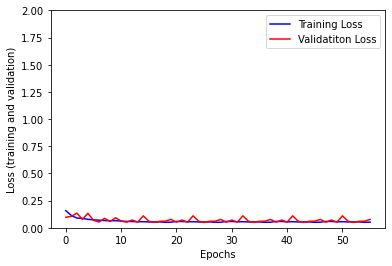

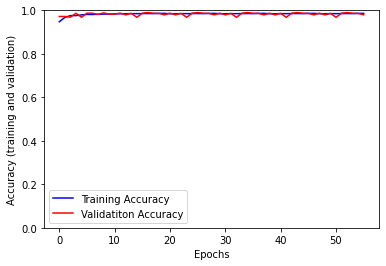

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Epochs")
plt.ylim([0,2])
plt.plot(losses, 'b', label='Training Loss')
plt.plot(val_losses, 'r', label='Validatiton Loss')
plt.legend()
plt.show()

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Epochs")
plt.ylim([0,1])
plt.plot(accuracies, 'b', label='Training Accuracy')
plt.plot(val_accuracies,'r', label='Validatiton Accuracy')
plt.legend()
plt.show()

#Testing AP/PA Classifier

In [ ]:
test_dses = {
    'CheXpert': cheXpert_ds,
    'CX-Net': CXNet_ds,
    'ActualMed': ActualMed_ds,
    'Shenzhen': Shenzhen_ds,
    'Montgomery': Montgomery_ds,
    'RICORD': RICORD_ds,
    'Kaggle': Kaggle_Test_ds
}

# fiddy_predictions = {}

In [ ]:
#taken from https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [ ]:
fiddy_predictions['CheXpert'] = [cheXpert_predictions_all, cheXpert_ds[1]]

In [ ]:
#adapted from https://ecode.dev/cnn-for-medical-imaging-using-tensorflow-2/

import time

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
# for test_ds_name in test_dses:
#   print('-'*40)
#   print('Now evaluating '+ test_ds_name)
#   test_ds = test_dses[test_ds_name][2]
#   score_test = model.evaluate(test_ds)

#   #Checking to see if the images are already decoded (DICOM datsets already were)
#   if not test_dses[test_ds_name][3]:
#     pixel_arrays = list(map(read_test_image, test_dses[test_ds_name][0]))
#     pixel_arrays = tf.convert_to_tensor(pixel_arrays)
#     start_time = time.time()
#     fiddy_predictions[test_ds_name] = [model.predict(pixel_arrays)]
#   else:
#     start_time = time.time()
#     pixel_arrays = tf.convert_to_tensor(list(map(read_test_dicom_image, test_dses[test_ds_name][0])))
#     fiddy_predictions[test_ds_name] = [model.predict(pixel_arrays)]

#   print("--- Prediction Time: %s seconds ---" % (time.time() - start_time))
#   print(f"--- Average Prediction Time: {(time.time() - start_time)/len(pixel_arrays)}")
#   fiddy_predictions[test_ds_name].append(test_dses[test_ds_name][1])

#   for name, value in zip(model.metrics_names, score_test):
#     print(name, ': ', value)
#   print('-'*40)
# %cache fiddy_predictions=fiddy_predictions

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix
from itertools import cycle
import seaborn as sns

# notice the threshold
def plot_cm(dataset_name, labels: np.ndarray, predictions: np.ndarray, p: float=0.5) -> ():
    cm = confusion_matrix(labels, predictions > p)
    # you can normalize the confusion matrix

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['AP','PA'], yticklabels=['AP','PA'])
    plt.title(f'{name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    print('AP (True Negatives): ', TN)
    print('Missed AP (False Positives): ', FP)
    print('Missed PA (False Negatives): ', FN)
    print('PA (True Positives): ', TP)
    print(f'True Accuracy: {(TP+TN)/(TN+FP+FN+TP)}')
    print(f'Sensitivity: {recall}')
    print(f'Specificity: {TN/(TN+FP)}')
    print(f'PPV: {precision}')
    print(f'NPV: {TN/(TN+FN)}')
    print(f'F-1 Score: {2 / (1/precision + 1/recall)}')
    print(f'Yo the Youden J thing is: {TN/(TN+FP)+recall-1}')



def plot_roc(test_ds_names, predictions_list, **kwargs) -> ():
  # fp, tp, _ = roc_curve(labels, predictions)
  colors = cycle(['darkorange','cornflowerblue', 'purple', 'forestgreen','hotpink', 'crimson', 'tomato'])
  plt.figure(figsize=(10,10))
  for name, predictions, color in zip(test_ds_names, predictions_list, colors):
    fpr, tpr, _ = roc_curve(predictions[1], predictions[0])
    try:
      auc_score = roc_auc_score(predictions[1], predictions[0])
    except:
      auc_score = 'NA'
    plt.plot(fpr, tpr, color=color, lw=2, label=f'ROC curve of {name}(area = {auc_score})')
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Reciving Operator Characteristic')
  plt.legend(loc="lower right")
  plt.show()

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# for name, testXY in zip(test_dses.keys(), fiddy_predictions.values()):
#   print('-'*40)
#   print('NOW SHOWING PLOTS FOR: ' + name)
#   p=Find_Optimal_Cutoff(testXY[1], testXY[0])[0]
#   plot_cm(name, testXY[1], testXY[0], p=p)
#   print(f'Yo optimal threshold is {p}')
#   print('-'*40)

# plot_roc(test_dses.keys(), fiddy_predictions.values())

Evaluate on test data


Creating new value for variable 'fiddy_predictions'


In [ ]:
fiddy_predictions['CheXpert'][0] = np.array(cheXpert_predictions_all)

----------------------------------------
NOW SHOWING PLOTS FOR: CheXpert
AP (True Negatives):  148284
Missed AP (False Positives):  3475
Missed PA (False Negatives):  442
PA (True Positives):  19011
True Accuracy: 0.9771219307057917
Sensitivity: 0.9772785688582738
Specificity: 0.9771018522789423
PPV: 0.8454593969581072
NPV: 0.997028091927437
F-1 Score: 0.9066024464102623
Yo the Youden J thing is: 0.9543804211372162
Yo optimal threshold is 0.007537547033280134
----------------------------------------
----------------------------------------
NOW SHOWING PLOTS FOR: CX-Net
AP (True Negatives):  101
Missed AP (False Positives):  86
Missed PA (False Negatives):  16
PA (True Positives):  18
True Accuracy: 0.5384615384615384
Sensitivity: 0.5294117647058824
Specificity: 0.5401069518716578
PPV: 0.17307692307692307
NPV: 0.8632478632478633
F-1 Score: 0.2608695652173913
Yo the Youden J thing is: 0.06951871657754016
Yo optimal threshold is 0.19019317626953125
----------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in long_scalars


AP (True Negatives):  0
Missed AP (False Positives):  0
Missed PA (False Negatives):  1
PA (True Positives):  661
True Accuracy: 0.9984894259818731
Sensitivity: 0.9984894259818731
Specificity: nan
PPV: 1.0
NPV: 0.0
F-1 Score: 0.999244142101285
Yo the Youden J thing is: nan
Yo optimal threshold is 0.0010623078560456634
----------------------------------------
----------------------------------------
NOW SHOWING PLOTS FOR: Montgomery
AP (True Negatives):  0
Missed AP (False Positives):  0
Missed PA (False Negatives):  1
PA (True Positives):  137
True Accuracy: 0.9927536231884058
Sensitivity: 0.9927536231884058
Specificity: nan
PPV: 1.0
NPV: 0.0
F-1 Score: 0.9963636363636362
Yo the Youden J thing is: nan
Yo optimal threshold is 0.038424089550971985
----------------------------------------
----------------------------------------
NOW SHOWING PLOTS FOR: RICORD
AP (True Negatives):  691
Missed AP (False Positives):  0
Missed PA (False Negatives):  1
PA (True Positives):  2
True Accuracy: 0.9

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


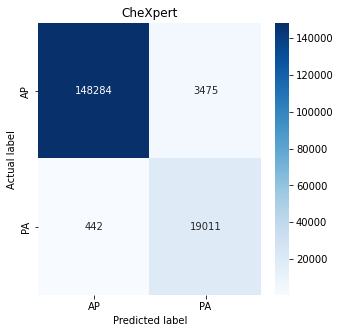

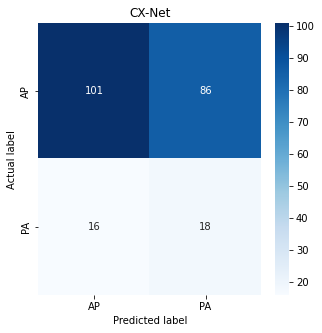

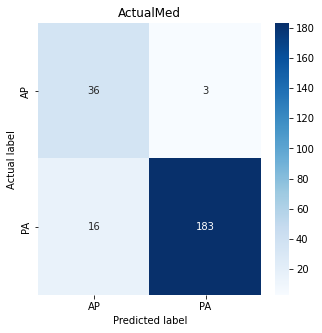

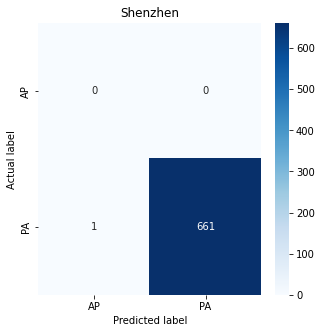

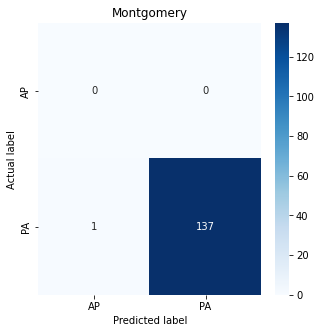

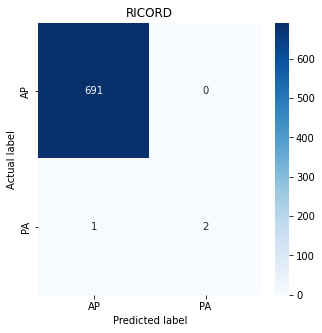

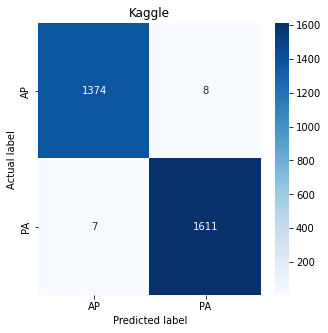

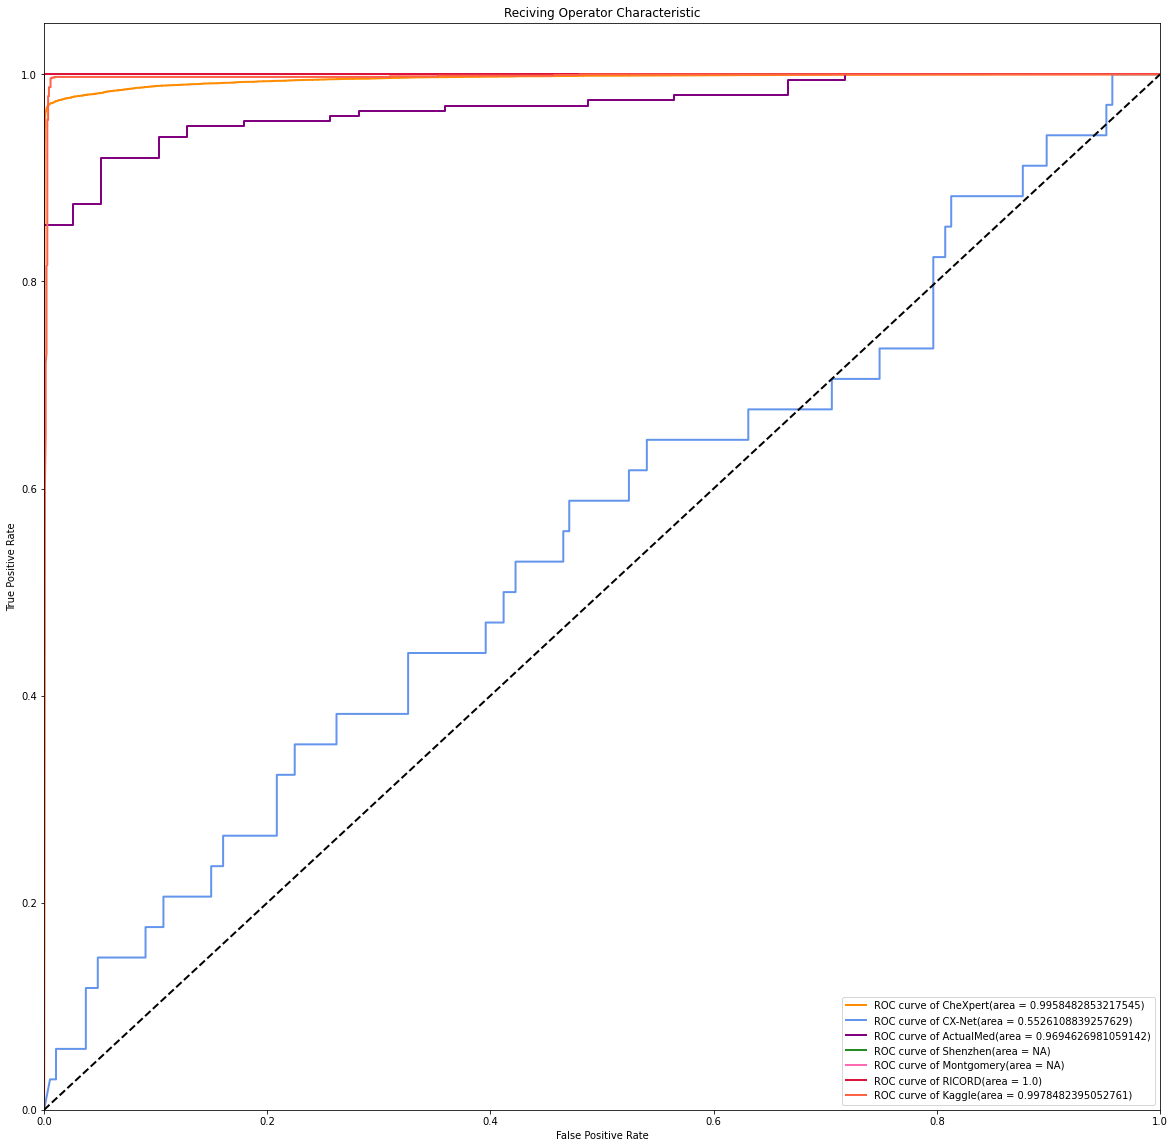

In [ ]:
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for name, testXY in zip(test_dses.keys(), fiddy_predictions.values()):
  print('-'*40)
  print('NOW SHOWING PLOTS FOR: ' + name)
  p=Find_Optimal_Cutoff(testXY[1], testXY[0])[0]
  plot_cm(name, testXY[1], testXY[0], p=p)
  print(f'Yo optimal threshold is {p}')
  print('-'*40)

plot_roc(test_dses.keys(), fiddy_predictions.values())

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


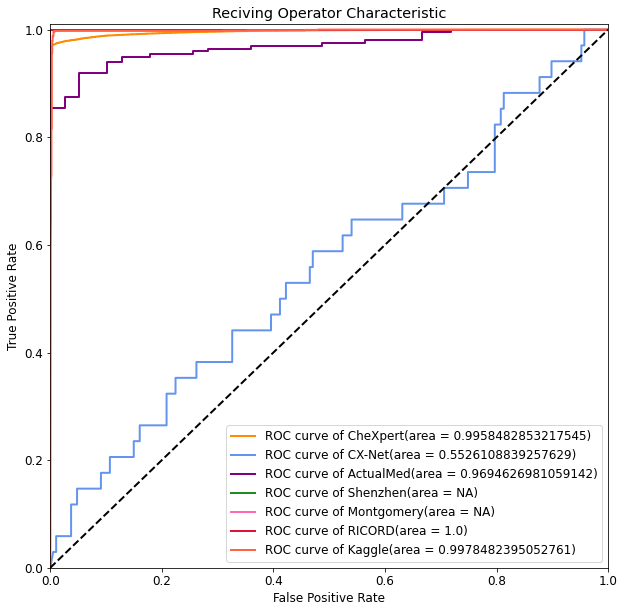

In [ ]:
plt.rcParams.update({'font.size': 12})

plot_roc(test_dses.keys(), fiddy_predictions.values())

In [116]:
#taken from https://keras.io/examples/vision/grad_cam/
import keras
import matplotlib.cm as cm
def make_gradcam_heatmap(img_array, dmodel, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    img_array = tf.expand_dims(img_array, axis=0)
    grad_model = tf.keras.models.Model(
        [dmodel.inputs], [dmodel.layers[-3].output, dmodel.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(grads)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    # pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    print(last_conv_layer_output)
    heatmap = last_conv_layer_output @ grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Rescale heatmap to a range 0-255
    img=tf.expand_dims(img, axis=0)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

image = read_test_image(cheXpert_ds[0][0])
heatmap = make_gradcam_heatmap(image, unwrapped)
save_and_display_gradcam(image, heatmap)


ValueError: ignored

In [104]:
def unwrap_model(model):
    inception = model.get_layer('efficientnetv2-m')
    unwrapped = tf.keras.Sequential()
    unwrapped.add(inception.input)
    unwrapped.add(inception.get_layer('stem'))
    for layer in inception.layers[:-2]:
      unwrapped.add(layer)
    unwrapped.add(inception.get_layer('head'))
    unwrapped.add(model.get_layer('dense_1'))
    unwrapped.build((None,)+(None,None)+(3,))
    return unwrapped

In [105]:
from tensorflow.keras.models import Model
unwrapped = unwrap_model(diag_model)

In [115]:
unwrapped.inputs

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>]

In [ ]:
k=model(np.array([read_test_image(cheXpert_ds[0][0])]))

# Diagnosis Model


In [8]:
import sys
# Download source code.
if "efficientnetv2" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientnetv2')
  sys.path.append('.')
else:
  !git pull

Already up to date.


In [10]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [11]:
import tensorflow_addons
import effnetv2_model
model_name = 'efficientnetv2-m'
efficientnet = effnetv2_model.get_model(model_name=model_name, include_top=False, weights='imagenet21k', training=True)

1195991040/1195979495 [==============================] - 11s 0us/step
Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stem (Stem)                  (None, 112, 112, 24)      744       
_________________________________________________________________
blocks_0 (FusedMBConvBlock)  (None, 112, 112, 24)      5280      
_________________________________________________________________
blocks_1 (FusedMBConvBlock)  (None, 112, 112, 24)      5280      
_________________________________________________________________
blocks_2 (FusedMBConvBlock)  (None, 112, 112, 24)      5280      
_________________________________________________________________
blocks_3 (FusedMBConvBlock)  (None, 56, 56, 48)        25920     
_________________________________________________________________
blocks_4 (FusedMBConvBlock)  (None, 56, 56, 48)        93120 

In [18]:
diag_model = tf.keras.Sequential()
# densenet = tf.keras.applications.densenet.DenseNet121(weights='imagenet')
# model_handle = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2'
# efficientNet = hub.KerasLayer(model_handle, trainable=True)

diag_model.add(model)
diag_model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid))
diag_model.build((None,)+(IMG_SIZE,IMG_SIZE)+(3,))
diag_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetv2-m (EffNetV2Mo (None, 1280)              53150388  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 53,151,669
Trainable params: 52,859,637
Non-trainable params: 292,032
_________________________________________________________________


In [22]:
#taken from https://ecode.dev/cnn-for-medical-imaging-using-tensorflow-2/
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import SpecificityAtSensitivity, SensitivityAtSpecificity

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      SpecificityAtSensitivity(.5, name='specificity'),
      SensitivityAtSpecificity(.5, name='sensitivity'),
]

In [23]:
diag_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=.9), 
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=METRICS)

In [24]:
BetterDir = '/content/drive/MyDrive/AP PA Stuff/Datasets/Tensorflow/daignosis/'
checkpoint_path = BetterDir + "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1, moniter=['tp','fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'specificity', 'sensitivity','val_tp','val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_specificity', 'val_sensitivity'])

In [31]:
class ClearStuff(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5)

In [ ]:
steps_per_epoch = dataset_length*.8 // BATCH_SIZE
validation_steps = dataset_length*.2 // BATCH_SIZE

def train(): 
  hist = diag_model.fit(
    train_ds,
    epochs=epoch_number, steps_per_epoch=steps_per_epoch,
    validation_data=valid_ds,
    validation_steps=validation_steps,
    callbacks=[cp_callback, ClearStuff(), reduce_lr]).history 
  return hist
hist=train()

###Training


In [25]:
import gc
# kaggle_metadata_path = colabDir + 'stage_2_train_images/stage_2_detailed_class_info.csv'
# kaggle_metadata = pd.read_csv(kaggle_metadata_path)
IMG_SIZE= 256
BATCH_SIZE = 32

def read_training_dataset(file_name, label):
  image = tf.io.read_file(file_name)
  if label == 999.0:
    # print(kaggle_metadata.loc[kaggle_metadata['patientId'] == id]['class'])
    image = tfio.image.decode_dicom_image(image)[0,:,:,:]
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.image.grayscale_to_rgb(image)
  else:
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  time.sleep(.002)
  gc.collect()
  return image, label


In [26]:
#TEST ON 13-24 FILE GROUPS AND KAGGLE TEST

In [27]:
Kaggle_AP = 0
Kaggle_PA = 0
IEEE_PA = 0
IEEE_AP = 0
epoch_number = 50
num_shards = 4

def train_gen(half=None):
  global file_count
  global Kaggle_AP
  global Kaggle_PA
  global IEEE_AP
  global IEEE_PA

  dataDir = 'NIH/'

  #Getting dcm file paths from premade folders
  #I manually Separated dcm into seperate folders bc google couldnt read 26k files in one line
  file_paths = []
  labels = []
  metadata_path = 'NIH Metadata.csv'
  file_dir_names = [str(i) for i in range(1,22)] #23-74 have rest of files
  metadata = pd.read_csv(colabDir + dataDir + metadata_path)
  for name in file_dir_names:
    file_dir = colabDir + dataDir + name + '/'
    files = os.listdir(file_dir)
    for file_ in files:
      file_paths.append(file_dir + file_)
      label = (metadata.loc[metadata['Image Index'] == file_]['Finding Labels'])
      if label.any() == 'No Finding':
        label = 0.0
      else:
        label = 1.0
      labels.append(label)


  #oop cheXpert time (run that cell first)
  name ='CheXpert Dataset'
  dataDir = 'CheXpert-v1.0-small/'

  #/content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train.csv
  #/content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/valid.csv
  METADATA_CSV_PATH = colabDir + dataDir + 'train.csv' #train metadata path
  METADATA_CSV_PATH2 = colabDir + dataDir + 'valid.csv' #validation metadata path
  metadata = pd.read_csv(METADATA_CSV_PATH)
  metadata2 = pd.read_csv(METADATA_CSV_PATH2)
  metadata = pd.concat([metadata, metadata2], ignore_index=True)

  #Only take 20k images
  metadata = metadata[:25000]

  #Getting image file paths from csv
  chexpert_file_paths = list(metadata['Path'].values)

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(chexpert_file_paths):
    chexpert_file_paths[ind] = colabDir + path
  #Get AP/PA label
  chexpert_labels = list(metadata['No Finding'].values)
  for ind, label in enumerate(chexpert_labels):
    if label != 1:
      chexpert_labels[ind] = 0.0
    else:
      chexpert_labels[ind] = 1.0

  labels.extend(chexpert_labels)
  file_paths.extend(chexpert_file_paths)

  for ind, label in enumerate(labels):
    if label == 999.0 or label == 0.0 or label == 1.0:
      continue
    elif int(label) == 1:
      labels[ind] = 1.0
    elif int(label) == 0:
      labels[ind] = 0.0
    else:
      raise


  zipped = list(zip(file_paths, labels))
  random.shuffle(zipped)

  ind=0
  # return labels
  while ind<len(zipped):
    image = tf.io.read_file(file_paths[ind])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    label = labels[ind]
    yield zipped[ind][0], zipped[ind][1]
    ind+=1

In [28]:
def create_train():
  dataset = tf.data.Dataset.from_generator(train_gen, output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), tf.TensorSpec(shape=(), dtype=tf.float32)))
  dataset = dataset.apply(tf.data.experimental.assert_cardinality(59999)) #34999(NIH) --20353 no finding, 14646 diseased + 25000(CheXpert)
  dataset_length = dataset.cardinality().numpy()
  buffer_size = int(.1 * dataset_length)
  # shard_size = -(-dataset_size // num_shards)
  
  # shuffled_shards = []
  # for i in shards:
  #     subshard = shard(i)
  #     subshard = subshard.interleave(lambda x: x, cycle_length=4, block_length=1)
  #     shuffled_shards.append(subshard.shuffle(buffer_size=buffer_size))
  # shuffled_shards = tf.data.Dataset.from_tensor_slices(shuffled_shards)
  # dataset = shuffled_shards.interleave(lambda x: x, cycle_length=4, block_length=1)
  # dataset = dataset.shuffle(num_shards)
  # print(dataset)
  dataset = dataset.shuffle(buffer_size=buffer_size)
  dataset = dataset.map(read_training_dataset, num_parallel_calls=tf.data.AUTOTUNE)

  print(dataset)
  dataset = dataset.map(normalize)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=.8, validation_prop=.2, testing_prop=0, train=True)
  train_ds = train_ds.map(lambda images, labels: (preprocessing_model(images), labels))
  train_ds = train_ds.batch(BATCH_SIZE).repeat(epoch_number).prefetch(tf.data.AUTOTUNE)
  valid_ds = valid_ds.batch(BATCH_SIZE).repeat(epoch_number).prefetch(tf.data.AUTOTUNE)
  # test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return dataset_length, train_ds, valid_ds, test_ds
dataset_length, train_ds, valid_ds, test_ds = create_train()

<ParallelMapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.float32)>
c
d
e
f
g
h
i
j


In [29]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
